# Convolutional Beta-Variational AutoEncoder ($\beta\text{-VAE}$)

### This notebook contains a Tensorflow Keras-based Convolutional Beta-Variational Auto-Encoder (using mixture of sub-classing and functional api) trained on a custom polyomino-based dataset.

In [97]:
import os
import random

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import sklearn

import seaborn as sns; sns.set()

In [98]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [99]:
# verify gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15757729870072013076
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7302152192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6180598613007515638
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [100]:
###### Constants ######
RANDOM_SEED=8675309
BATCH_SIZE=128
MAX_EPOCHS=500
PERCENT_VAL=0.01 # percentage of test data used for validation

# Autoencoder Parameters
LATENT_DIM = 4
INPUT_SHAPE = (128, 128, 1)
BETA = 1.1  # Penalty coefficient on KL divergence (used to pressure the latent representations to be disentangled)

# Save/Load Model Constants
SAVE_PATH = os.path.join('..', 'models', 'cvae-poly')

LOADING_WEIGHTS = False
SAVING_WEIGHTS = False
TRAINING = True

In [101]:
###### Function Definitions ######
def get_xy(dataset):
  """ populates x and y numpy arrays for dataset (e.g., images and their labels) """
  xs, ys = None, None

  for x, y in list(dataset.as_numpy_iterator()):
    xs = x if xs is None else np.append(xs, x, axis=0)
    ys = y if ys is None else np.append(ys, y, axis=0)

  return xs, ys


def display_images(images, rows=1, cols=1, dpi=128, wspace=0, hspace=0, labels=None):
    fig = plt.figure(dpi=dpi)

    spec = gs.GridSpec(rows, cols)
    spec.update(wspace=wspace, hspace=hspace)

    i = 0
    for image in images:
        image = image if type(image) is np.ndarray else image.numpy()
        image = image.reshape(image.shape[:-1]) # remove channel
        ax = plt.subplot(spec[i])
        
        if labels:
            plt.title(labels[i])
            
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image, cmap=plt.cm.binary)
        i += 1
        
    plt.show()

    return fig
    

def plot_history(history, metrics, figsize=(15,10)):
    plt.figure(figsize=figsize)

    for i, metrics in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        for metric in metrics:
            plt.plot(range(len(history.epoch)), history.history[metric], label=metric)
        plt.legend(loc='upper right')        

In [102]:
# uncomment for Colab runtime
# ! wget 'https://github.com/skugele/ml-datasets/raw/master/polyomino/polyomino.zip'
# ! unzip -n polyomino.zip -d data 1>/dev/null

In [103]:
ds_options = {
    'directory': '../data/images',
    'labels': 'inferred',
    'label_mode': "int",
    'color_mode': "grayscale",
    'batch_size': BATCH_SIZE,
    'image_size': INPUT_SHAPE[0:2],
    'shuffle': True,
    'seed': RANDOM_SEED,
    'validation_split': PERCENT_VAL,
    'class_names': list(map(str, range(1,30)))
}

train_ds_with_labels = tf.keras.utils.image_dataset_from_directory(**ds_options, subset='training')
val_ds_with_labels = tf.keras.utils.image_dataset_from_directory(**ds_options, subset='validation')

# remove labels from datasets
train_ds = train_ds_with_labels.map(lambda x,y: x)
val_ds = val_ds_with_labels.map(lambda x,y: x)

# populate numpy arrays with images and their corresponding labels.
# note: these are used exclusively for model analysis.
x_train, y_train = get_xy(train_ds_with_labels)
x_val, y_val = get_xy(val_ds_with_labels)

Found 1899 files belonging to 29 classes.
Using 1881 files for training.
Found 1899 files belonging to 29 classes.
Using 18 files for validation.


## Visualizing a Few Exemplars from the **TRAINING** Data Set

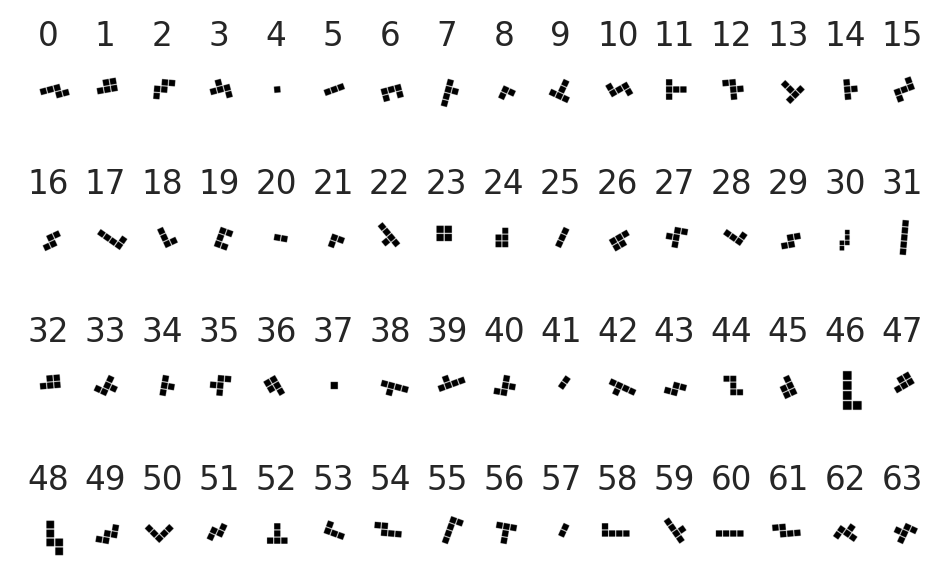

In [104]:
n = 64
fig = display_images(x_train[0:n], rows=4, cols=16, dpi=196, labels=range(n))

# Defining the $\beta\text{-VAE}$ Model


## The model contains the following components:

<h3>
<ol>
    <li> Preprocessor </li>
    <li> Encoder </li>
    <li> Latent Vector Sampler </li>
    <li> Decoder </li>
    <li> Loss Function (Reconstruction Loss + KL-Divergence) </li>
</ol>

    Note: Our loss function encourages a normally distributed prior $p(z)$ and a Gaussian posterior approximation $q(z|x)$.
    
</h3>

In [105]:
class Preprocessor(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__(name="preprocessor")

    # layers
    self.rescale = tf.keras.layers.Rescaling(scale=1.0/255.0, name="proprocessor/rescale")

  def call(self, inputs):
    x = self.rescale(inputs)
    return x

In [106]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dim):
    super().__init__(name="encoder")
    
    self.latent_dim = latent_dim
    
    # layers
    self.preprocessor = Preprocessor()
    self.conv1 = tf.keras.layers.Conv2D(
      filters=64, 
      kernel_size=2, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv1')
    self.maxpool1 = tf.keras.layers.MaxPool2D(name='encoder/maxpool1')
    self.conv2 = tf.keras.layers.Conv2D(
      filters=32, 
      kernel_size=3, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv2')
    self.maxpool2 = tf.keras.layers.MaxPool2D(name='encoder/maxpool2')
    self.conv3 = tf.keras.layers.Conv2D(
      filters=32, 
      kernel_size=4, 
      strides=(1, 1), 
      padding='same', 
      activation='relu', 
      name='encoder/conv3')
    self.maxpool3 = tf.keras.layers.MaxPool2D(name='encoder/maxpool3')
    self.flatten = tf.keras.layers.Flatten(name='encoder/flatten')        
    self.logvar = tf.keras.layers.Dense(latent_dim, name='encoder/logvar')
    self.mu = tf.keras.layers.Dense(latent_dim, name='encoder/mu')
    self.sigma = tf.keras.layers.Lambda(lambda t: tf.keras.backend.exp(.5*t), name='encoder/sigma')
      
  def call(self, inputs):
    p = self.preprocessor(inputs)
    x = self.conv1(p)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.maxpool3(x)
    x = self.flatten(x)   
    return self.mu(x), self.logvar(x), self.sigma(self.logvar(x)), p

In [107]:
class Sampler(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="sampler")
        
    def call(self, inputs):
        mu, sigma = inputs
        
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        
        # Gaussian noise
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mu + sigma * epsilon

In [108]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__(name="decoder")
        
        # layers
        self.dense1 = tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu, name='decoder/dense1')
        self.reshape1 = tf.keras.layers.Reshape(target_shape=(8, 8, 64), name='decoder/reshape1')
        self.trans_conv1 = tf.keras.layers.Conv2DTranspose(
          filters=64,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv1')
        self.trans_conv2 = tf.keras.layers.Conv2DTranspose(
          filters=32,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv2')
        self.trans_conv3 = tf.keras.layers.Conv2DTranspose(
          filters=16,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv3')
        self.trans_conv4 = tf.keras.layers.Conv2DTranspose(
          filters=8,
          kernel_size=2,
          strides=(2, 2),
          padding='same',
          activation='relu',
          name='decoder/deconv4')
        self.trans_conv5 = tf.keras.layers.Conv2DTranspose(
          filters=1,
          kernel_size=2,
          strides=(1, 1),
          padding='same',
          activation='sigmoid',
          name='decoder/deconv5')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape1(x)
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)
        x = self.trans_conv3(x) 
        x = self.trans_conv4(x)
        return self.trans_conv5(x) 

In [109]:
# preprocessor = Preprocessor()
# encoder = Encoder(latent_dim=LATENT_DIM)
# sampler = Sampler()
# decoder = Decoder()

# inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input")
# mu, logvar, sigma, x = encoder(inputs)
# z = sampler((mu, sigma))
# x_recon = decoder(z) 

# VAE Loss Function
<h2>
$
\begin{align}
\DeclareMathOperator{\ExpectedVal}{\mathbf{E}}
\DeclareMathOperator{\log}{\operatorname{log}}
\mathcal{L}(\theta, \phi; \mathbf{x}^{(i)}) = -D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z})) + \ExpectedVal_{q_\phi(\mathbf{z}\vert\mathbf{x^{(i)}})}\big[\log p_\theta(\mathbf{x}^{(i)}\vert \mathbf{z})\big],
\end{align}
$ 
<br><br>
where $D_{KL}$ is the KL-divergence.
<br><br><br><br>
If we assume that $p_\theta(\mathbf{z}) = \mathcal{N}(0, 1) \text{ and } q_\phi(\mathbf{z}\vert \mathbf{x}^{(i)})$ is Gaussian, then the KL-divergence can be integrated analytically and has the value
$    
\begin{align}
\DeclareMathOperator{\log}{\operatorname{log}}
D_{KL}(q_\phi(\mathbf{z} \vert \mathbf{x}^{(i)}) \| p_\theta(\mathbf{z}) = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2),
\end{align}
$
<br>
where $J$ is the dimensionality of the latent vector $z$.
</h2>

In [110]:
# Custom loss layer for reconstruction
class ReconstructionLoss(tf.keras.layers.Layer):
    def __init__(self):
      super(ReconstructionLoss, self).__init__(name="recon_loss")
      self.is_placeholder = True

    def call(self, inputs):
        x = inputs[0]
        x_recon = inputs[1]
        
        recon_loss = tf.keras.backend.sum(tf.keras.backend.binary_crossentropy(x, x_recon), axis=(1,2))
        recon_loss = tf.keras.backend.mean(recon_loss)
        
        self.add_loss(recon_loss, inputs=inputs)
        
        return recon_loss

# Custom loss layer for kl-loss
class KLLoss(tf.keras.layers.Layer):
    def __init__(self, beta=1.0):
      super(KLLoss, self).__init__(name="kl_loss")
      self.is_placeholder = True
              
      self.beta = beta

    def call(self, inputs):
        mu = inputs[0]
        logvar = inputs[1]
        
        # KL Divergence for Gaussian Distributions (see Kingma and Welling, 2014, p.11)
        # --> Assumes that the prior p(z) is normal and the posterior approximation q(z|x) is Gaussian
        kl_loss = -0.5 * self.beta * tf.keras.backend.sum(
            1.0 + logvar - tf.keras.backend.square(mu) - tf.keras.backend.exp(logvar), axis=-1)
        kl_loss = tf.keras.backend.mean(kl_loss)
        
        self.add_loss(kl_loss, inputs=inputs)
        
        return kl_loss

In [ ]:
class BetaCVAE(tf.keras.Model):
    def __init__(self, latent_dims, beta=1.0):
        super().__init__()
        
        self.encoder = Encoder(latent_dims)
        self.sampler = Sampler()
        self.decoder = Decoder()
        
        self.recon_loss = ReconstructionLoss()
        self.kl_loss = KLLoss(beta)
        
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def call(self, inputs):
       
        mu, logvar, sigma, x = self.encoder(inputs)
        z = self.sampler((mu, sigma))
        x_recon = self.decoder(z)
        
        kl_loss = self.kl_loss([mu, logvar])
        recon_loss = self.recon_loss([x, x_recon])
        loss = kl_loss + recon_loss
        
        self.loss_tracker.update_state(loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return x_recon, recon_loss, kl_loss
        
        

In [126]:
vae = BetaCVAE(latent_dims=LATENT_DIM, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=None)

## Visualize Reconstruction of Sampled Images *PRIOR TO TRAINING*.

### this should look like random noise (if not loading weights from a saved model)

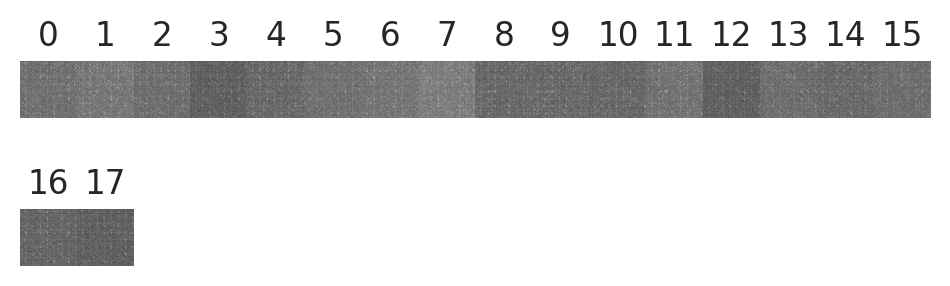

In [129]:
n = 64

# visualize generation before training
if TRAINING:
    images = x_val[0:n]

    xs, _, _ = vae(images)  # reconstructed images

    display_images(images=xs[0:n], rows=4, cols=16, dpi=196, labels=range(n))

In [132]:
# tf.keras.utils.plot_model(vae)

In [134]:
vae.summary()

Model: "beta_cvae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  100744    
_________________________________________________________________
sampler (Sampler)            multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  47769     
_________________________________________________________________
recon_loss (ReconstructionLo multiple                  0         
_________________________________________________________________
kl_loss (KLLoss)             multiple                  0         
Total params: 148,519
Trainable params: 148,513
Non-trainable params: 6
_________________________________________________________________


## Train The Model and Display Metrics For Model Performance on **Training** and **Validation** Data Sets

In [135]:
# tf.autograph.set_verbosity(10)
if TRAINING:
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    history = vae.fit(
        train_ds, 
        callbacks=[early_stop_callback],              
        epochs=MAX_EPOCHS, 
        validation_data=val_ds,
        verbose=1
    )
    
    plot_history(history, metrics=[('loss', 'val_loss')])

Epoch 1/500
15/15 [==============================] - 3s 108ms/step - total_loss: 11008.1143 - recon_loss: 10924.4902 - kl_loss: 83.6241 - val_total_loss: 10152.6641 - val_recon_loss: 9622.3008 - val_kl_loss: 530.3636
Epoch 2/500
15/15 [==============================] - 1s 91ms/step - total_loss: 6692.8032 - recon_loss: 5889.7861 - kl_loss: 803.0169 - val_total_loss: 3268.7449 - val_recon_loss: 2660.6853 - val_kl_loss: 608.0596
Epoch 3/500
15/15 [==============================] - 1s 91ms/step - total_loss: 2496.1917 - recon_loss: 2303.1553 - kl_loss: 193.0368 - val_total_loss: 2161.7534 - val_recon_loss: 2068.5557 - val_kl_loss: 93.1977
Epoch 4/500
15/15 [==============================] - 1s 90ms/step - total_loss: 2126.5833 - recon_loss: 2075.0283 - kl_loss: 51.5550 - val_total_loss: 2062.7925 - val_recon_loss: 2021.8413 - val_kl_loss: 40.9511
Epoch 5/500
15/15 [==============================] - 1s 90ms/step - total_loss: 2056.4062 - recon_loss: 2023.3159 - kl_loss: 33.0904 - val_total

KeyboardInterrupt: 

In [78]:
if SAVING_WEIGHTS:
    try:
        model.save_weights(SAVE_PATH, save_format='tf')
    except Exception as e:
        print(e)
        
elif LOADING_WEIGHTS:
    try:
        model.load_weights(SAVE_PATH)
    except Exception as e:
        print(e)

## Visualize Reconstruction of Sampled Images *AFTER TRAINING*.

### note: these are images from the **VALIDATION** data set: the auto-encoder was NOT trained on these!

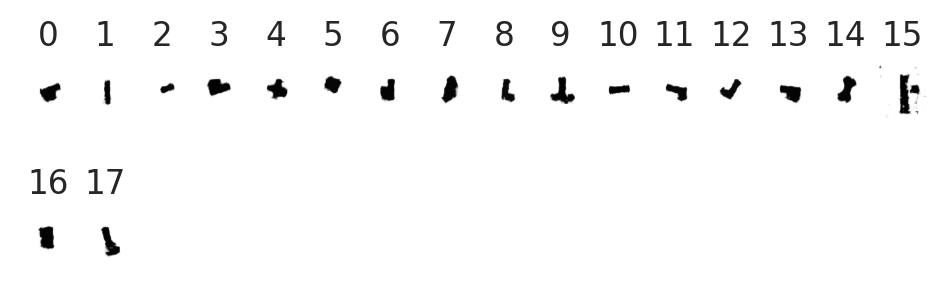

In [79]:
n = 64

# visualize generation after training
xs_recon, _, _ = model(x_val[0:n]) # latent vectors

fig = display_images(xs_recon[0:n], rows=4, cols=16, dpi=196, labels=range(n))

# Comparison between Original Images and Reconstructions

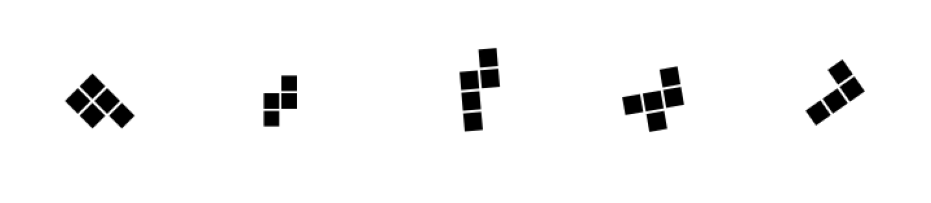

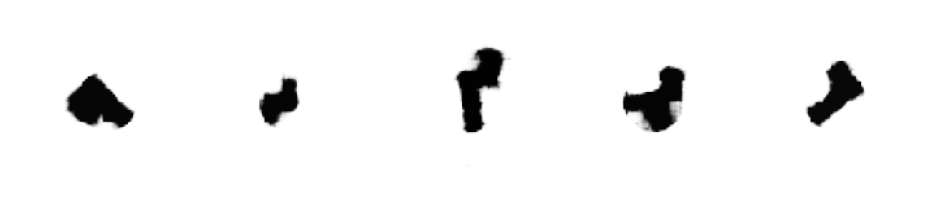

In [80]:
n = 5
idxs = np.random.uniform(0, len(x_train), size=n).astype(int)
images = x_train[idxs]

mu, _, sigma, xs = encoder(images)
zs = sampler((mu, sigma))
xs_recon = decoder(zs)

fig = display_images(xs, rows=1, cols=n, wspace=0.1, dpi=192)
fig = display_images(xs_recon, rows=1, cols=n, wspace=0.1, dpi=192)
# fig.savefig('recon.svg', format='svg', dpi=500)

<hr>
<h1> Cosine Similarity Over Learned Gaussians </h1>
<h2>
$
\begin{align}
\text{cosine similarity}(\vec{u}, \vec{v}) \equiv \frac{\vec{u} \cdot \vec{v}}{\| u \| \| v \|}
\end{align}
$
</h2>

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

## Illustration of Cosine Similarity Distance Metric 

In [24]:
# Examples for cosine similarity distance metric

# identical vectors
u = np.random.rand(100)
v = u

cosine_similarity([u, v])

array([[1., 1.],
       [1., 1.]])

In [25]:
# orthogonal vectors
u = np.random.rand(100)
v = np.random.rand(100)

# apply Gram-Schmidt to make v orthogonal to u
v -= v.dot(u) * u / np.linalg.norm(u)**2

cosine_similarity([u, v])

array([[1., 0.],
       [0., 1.]])

In [26]:
# opposite vectors
u = np.random.rand(100)
v = -u

cosine_similarity([u, v])

array([[ 1., -1.],
       [-1.,  1.]])

## Most Similar Exemplars (based on cosine similarity)

## Randomly select training images from each class

In [44]:
n_classes = len(np.unique(y_train))
n_samples_per_class = 5

np.random.seed(RANDOM_SEED)
imgs = np.concatenate([x_train[np.random.choice(np.reshape(np.argwhere(y_train==cls), -1), 
                                                n_samples_per_class, replace=False)] for cls in range(n_classes)], axis=0)

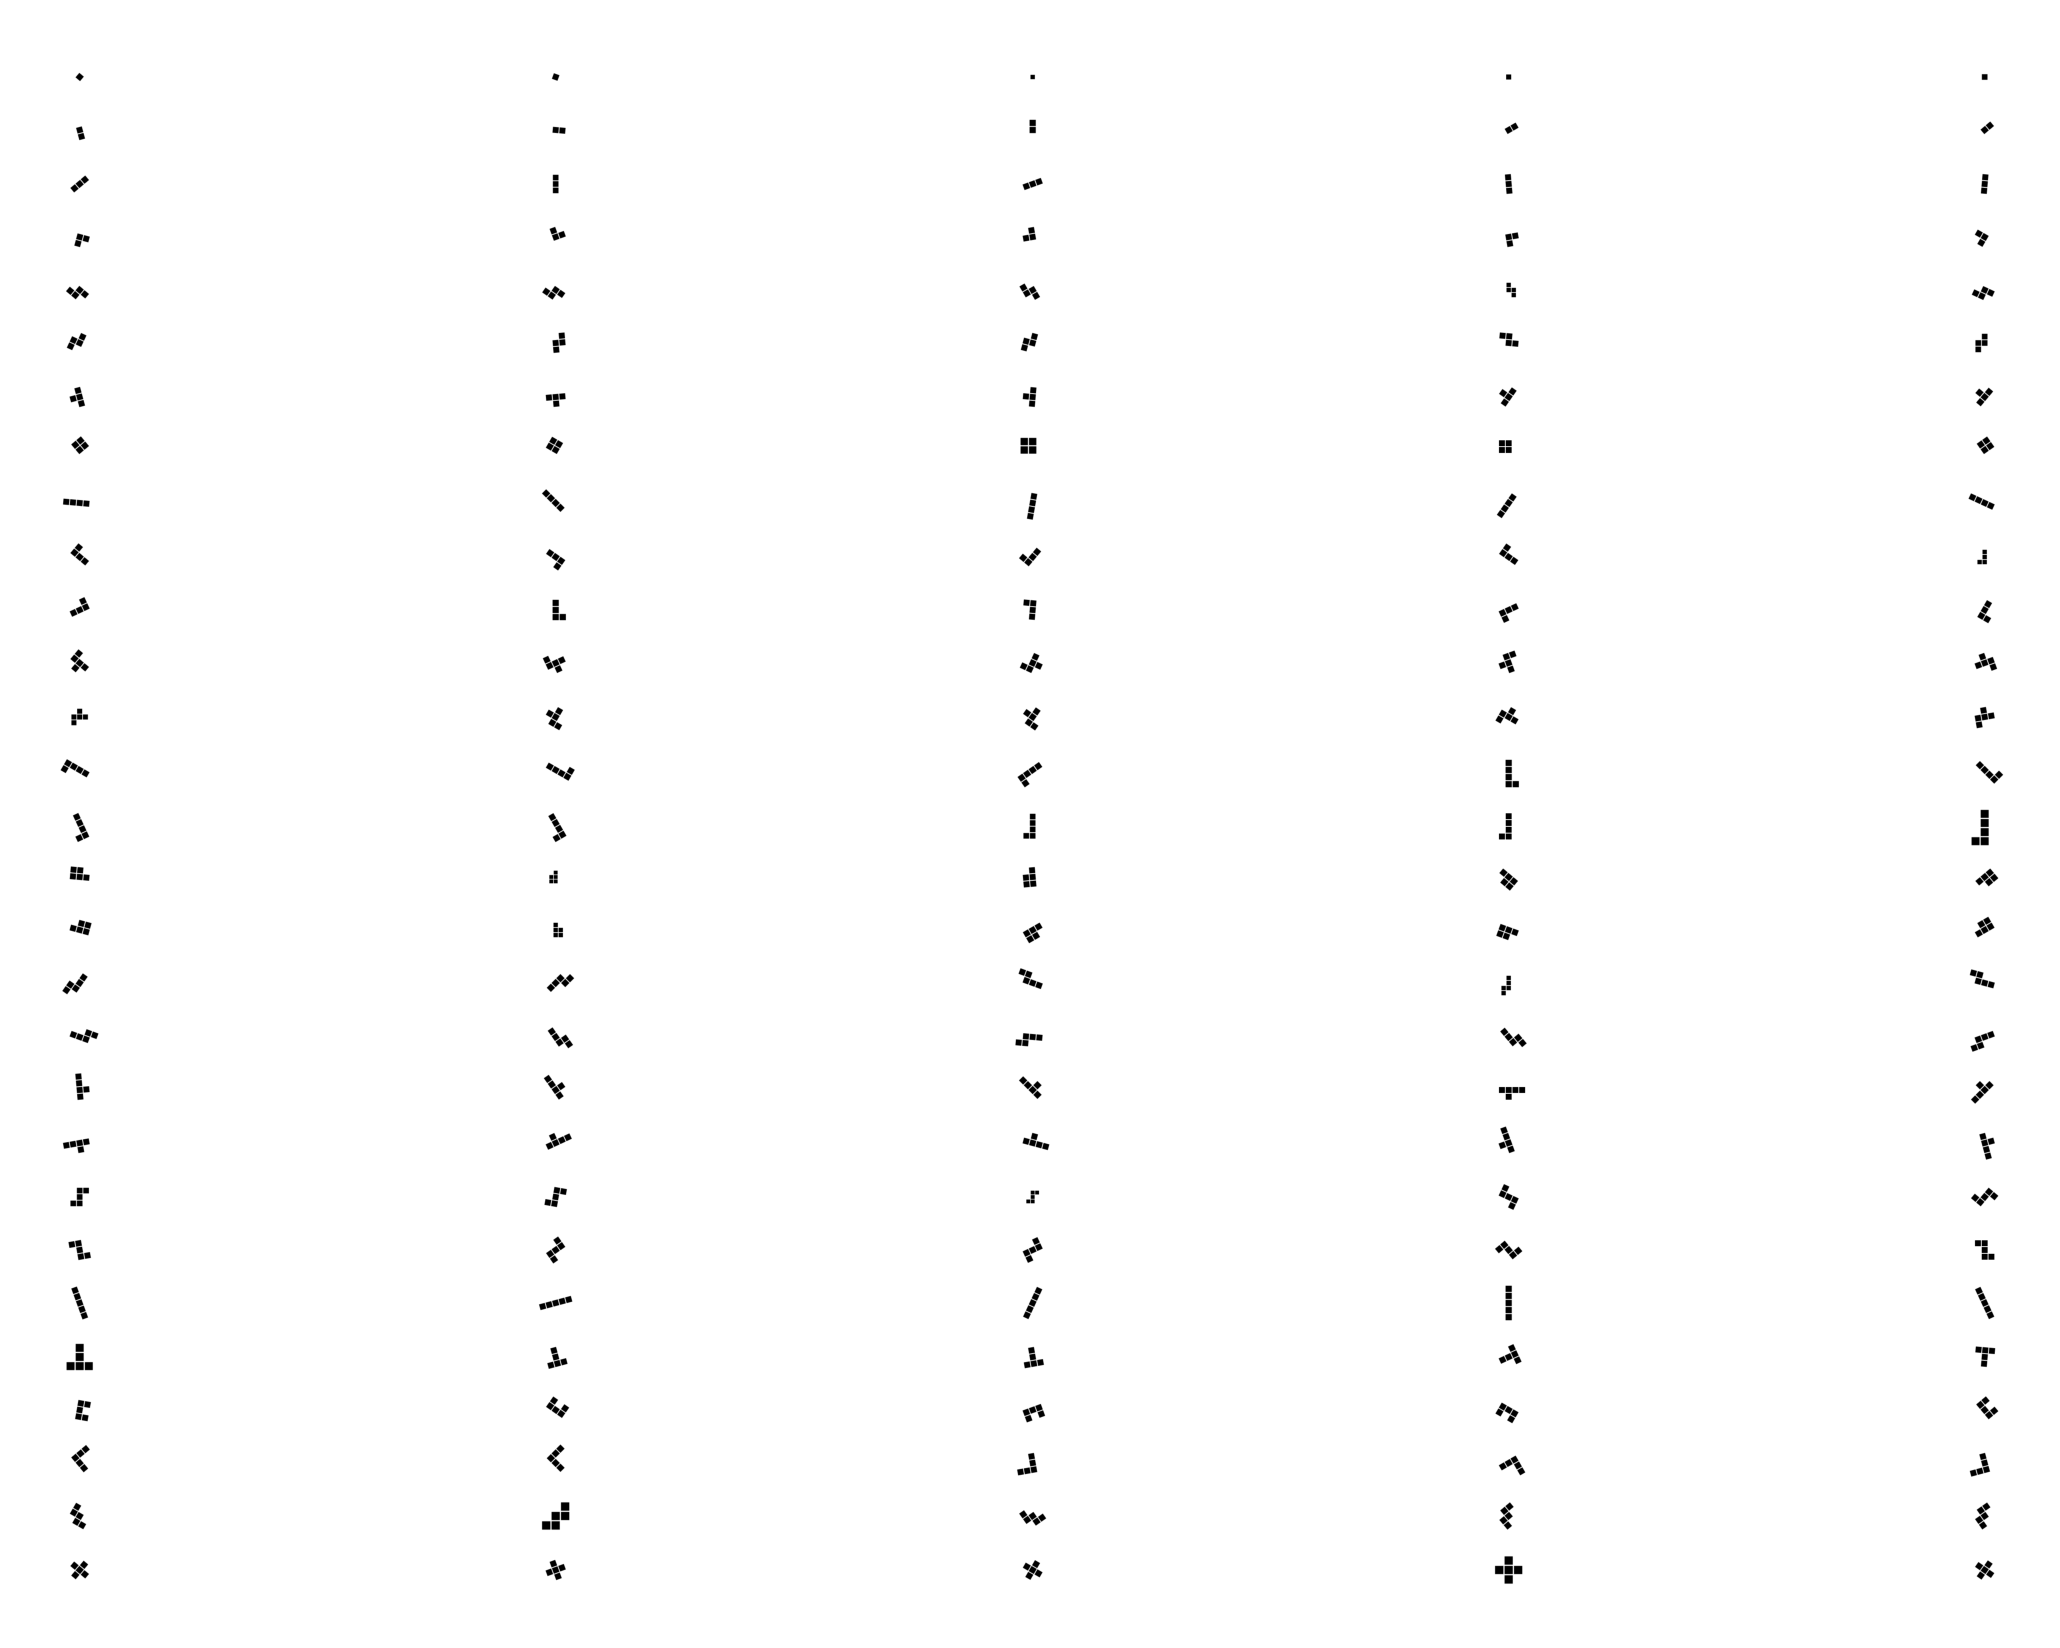

In [45]:
fig = display_images(imgs, n_classes, n_samples_per_class, dpi=512)

In [ ]:
n_classes = np.unique(y_train).shape[0]
n_samples_per_class = 4

## Calculate Cosine Similarity Distance Matrix Using Means ($\vec{\mu}$) Of Latent Prob. Distributions

In [31]:
mus, _, sigmas, xs = encoder(imgs)
zs = sampler((mus, sigmas))
xs_recon = decoder(zs)

In [32]:
dist_matrix = cosine_similarity(mus)
dist_matrix = np.round(dist_matrix, decimals=4)

In [33]:
# Functions to Facilitate Analysis

def get_n_similar(images, index, matrix, n, reversed=False):
    
    # ranks images by distance from reference image (descending order)
    ranked_indices_with_dist = np.array(
        sorted(
            np.array(list(enumerate(matrix[index]))), # matrix of image indices and their corresponding current activations
            key=lambda x: x[1], # key on activation
            reverse=not reversed)) # if reversed then least similar appear first in result
    
    return ranked_indices_with_dist[0:n,:]


def show_heatmap(matrix, n, n_per_class):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 11
    BIGGER_SIZE = 12

    plt.rcParams['font.family'] ='Times New Roman'

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

    fig = plt.figure(dpi=256)
    ax = fig.gca()
    im = ax.imshow(matrix, cmap='hot', interpolation='gaussian')
    ax.set_xticks(np.arange(0, n + 1, n_per_class))
    ax.set_yticks(np.arange(0, n + 1, n_per_class))

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='major', color='gray', linestyle='-', linewidth=0.25)

    cb = plt.colorbar(im)
    cb.set_ticks([])

    plt.show()

    # uncomment to export figure
    # fig.savefig('curr_act_heatmap.svg', format='svg', dpi=300)

    
def show_confusion_matrix(matrix, n_per_class):
    SMALL_SIZE = 6
    MEDIUM_SIZE = 9
    BIGGER_SIZE = 10

    plt.rcParams['font.family'] ='Times New Roman'

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

    fig = plt.figure(dpi=192)

    ax = sns.heatmap(matrix, annot=True, vmax=n_per_class, linewidths=.5, cmap="gist_gray", xticklabels=True, yticklabels=True)
    ax.set_xlabel("Object Class (Predicted)")
    ax.set_ylabel("Object Class (Actual)")

    # fix issue with plot cutting off top and bottom of image
    b, t = ax.get_ylim()
    b += 0.5
    t -= 0.5
    ax.set_ylim(b,t)

    plt.show()
    # fig.savefig('knn_confmatrix.svg', format='svg')

## Apply A Sigmoidal Activation Function (denoted $\alpha_c$) To Cosine Similarities (denoted $\delta$)

<h3>
Ideally, we want this activation function to have the following properties:

1. if $\delta(x,y)$ is close to 1.0 then $\delta(x,y) \approx \alpha_c(\delta(x,y))$
2. if $\delta(x,y)$ < instantiation threshold then $\alpha_c(\delta(x,y)$ should be dampened towards 0.0
                                                                         
</h3>


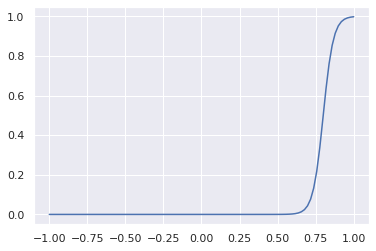

In [34]:
def curr_activation(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*x+b))

# activation function parameters (a = 1.0, b = 0.0 gives standard logistic function)
a = 30.0 # steepness of curve
b = a * 0.8 # horizontal shift

x = np.linspace(-1.0, 1.0, 100)
y = curr_activation(x, a, b) 
fig = plt.plot(x,y)

In [35]:
using_activation = True

# Passing the cosine similarity through a sigmoidal activation function
act_matrix = np.copy(dist_matrix)

if using_activation:
    act_matrix = curr_activation(act_matrix, a, b)
    
act_matrix = np.round(act_matrix, decimals=4)

## Create a Heatmap Showing $\alpha_c$

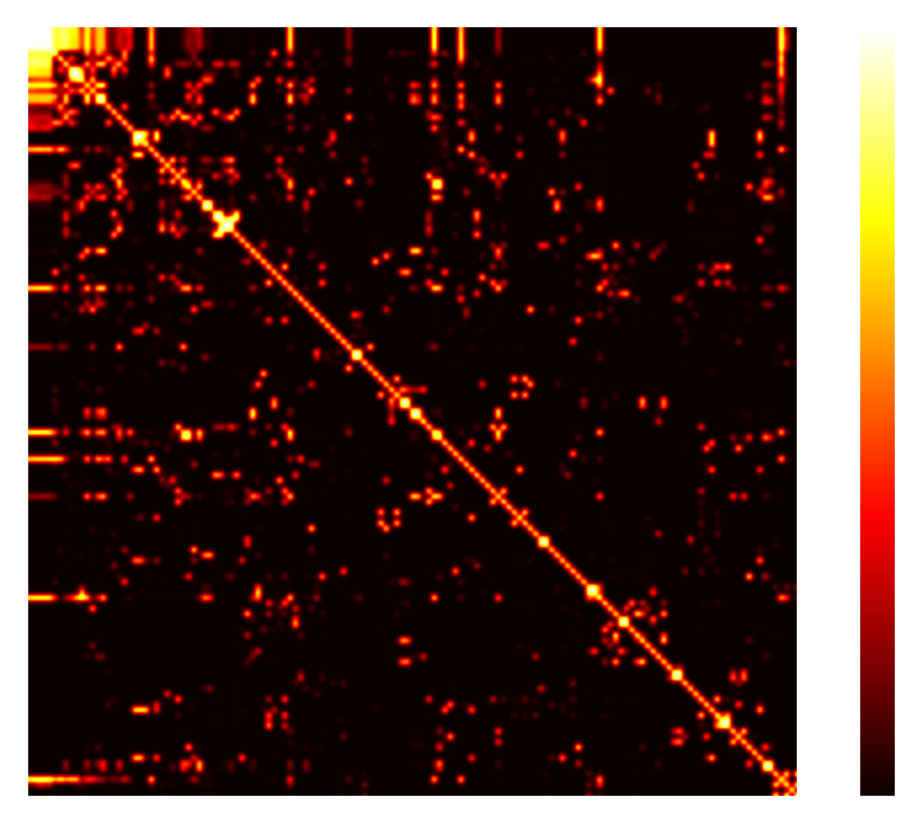

In [36]:
show_heatmap(act_matrix, n=len(imgs), n_per_class=n_samples_per_class)

## Find the Most (or Least) Similar Images for a Given Input

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


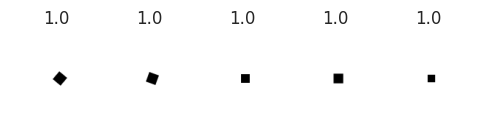

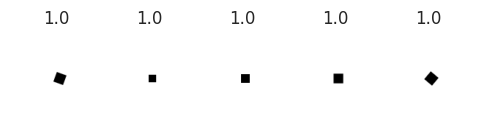

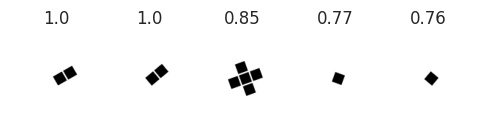

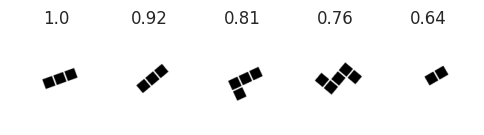

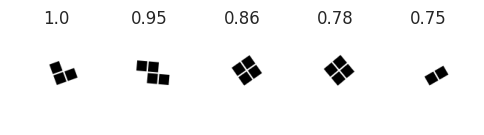

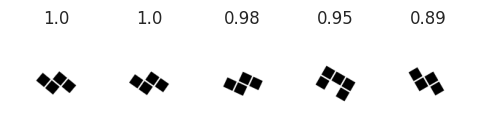

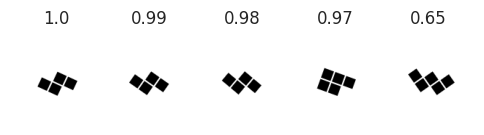

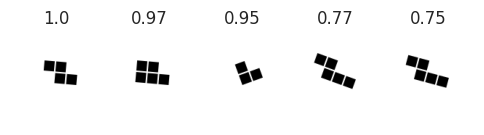

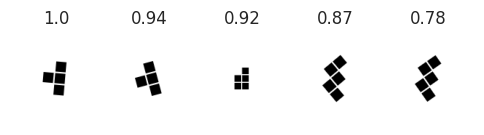

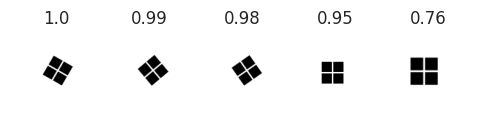

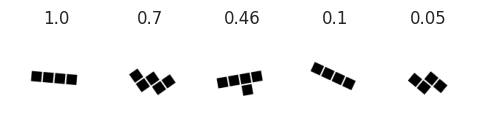

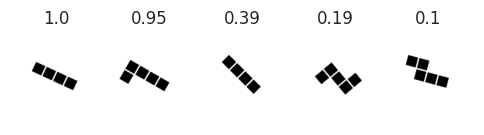

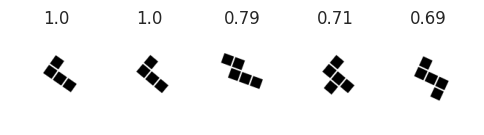

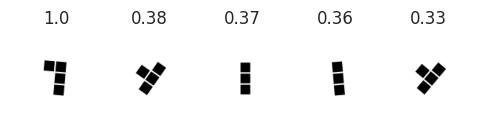

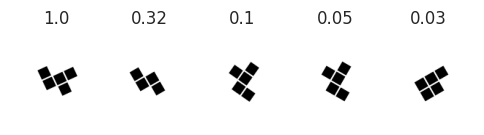

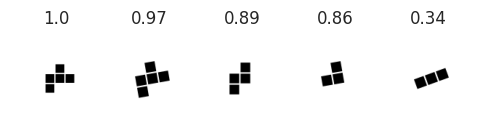

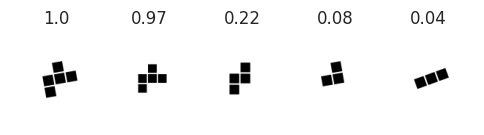

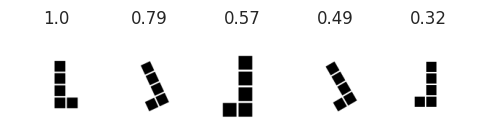

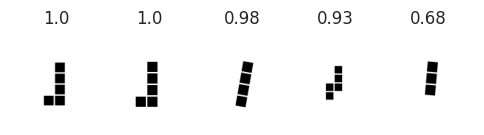

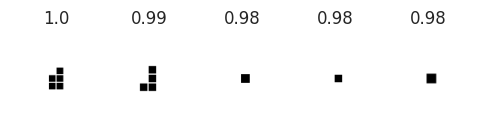

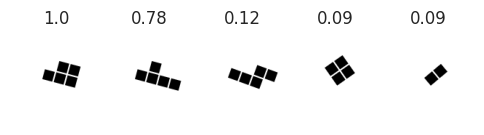

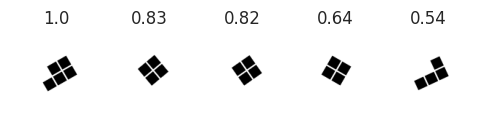

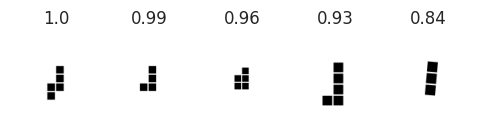

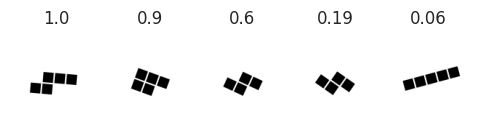

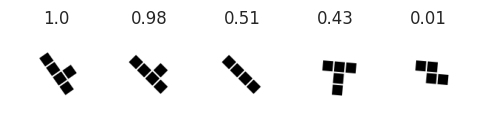

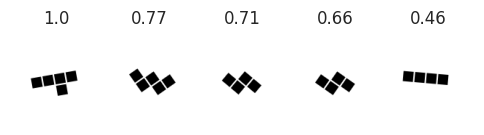

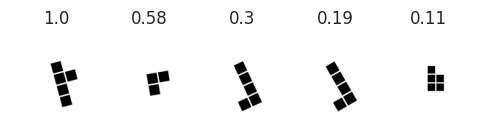

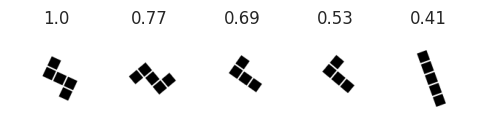

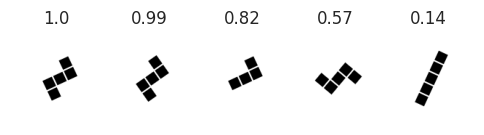

In [37]:
n = 5
ref_ndxs = range(0, n_samples_per_class*n_classes, n_samples_per_class)

curr_class = 0
for ndx in ref_ndxs:
    sims = get_n_similar(imgs, ndx, act_matrix, n)
    
    indices = sims[:,0].astype(int)
    dists = list(map(str, np.round(sims[:,1], decimals=2)))
    
    fig = display_images(imgs[indices], rows=1, cols=len(indices), labels=dists, dpi=100)
    
    # uncomment to export figure
    # fig.savefig('{cls}_distance_from_ref_image.svg'.format(cls=curr_class), format='svg', dpi=100)
    
    curr_class += 1

## K-nearest neighbors (KNN) using latent similarities and activation function

In [38]:
n_exemplars = dist_matrix.shape[0]

conf_matrix = np.zeros(shape=(n_classes + 1, n_classes + 1))
k = 3
threhold = 0.9 # instantiation threshold

UNK_VALUE = np.array([[n_exemplars + 1, 0.0]])

for ndx in range(n_exemplars):
    
    # k most similar (removing "best match", which will be a self-reference)
    k_similar_set = get_n_similar(imgs, ndx, act_matrix, k + 1)[1:]
    
    # remove examples below threshold
    k_similar_set = k_similar_set[k_similar_set[:,1] > threhold]
        
    # if all examples below threshold add UNKNOWN index
    if len(k_similar_set) == 0:
        k_similar_set = UNK_VALUE

    # calculate the object classes from indicies for most (cosine) similar
    obj_classes = k_similar_set[:,0].astype(int) // n_samples_per_class
    
    # determine best object class as object class with max number of members in most_similar_set
    predicted_class = np.argmax(np.bincount(obj_classes))
    actual_class = ndx // n_samples_per_class 
    
    conf_matrix[actual_class, predicted_class] += 1
        
print('overall accuracy: ', sum(np.diag(conf_matrix[0:10, 0:10]))/ np.sum(conf_matrix[0:10, 0:10]))

IndexError: index 36 is out of bounds for axis 1 with size 30

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


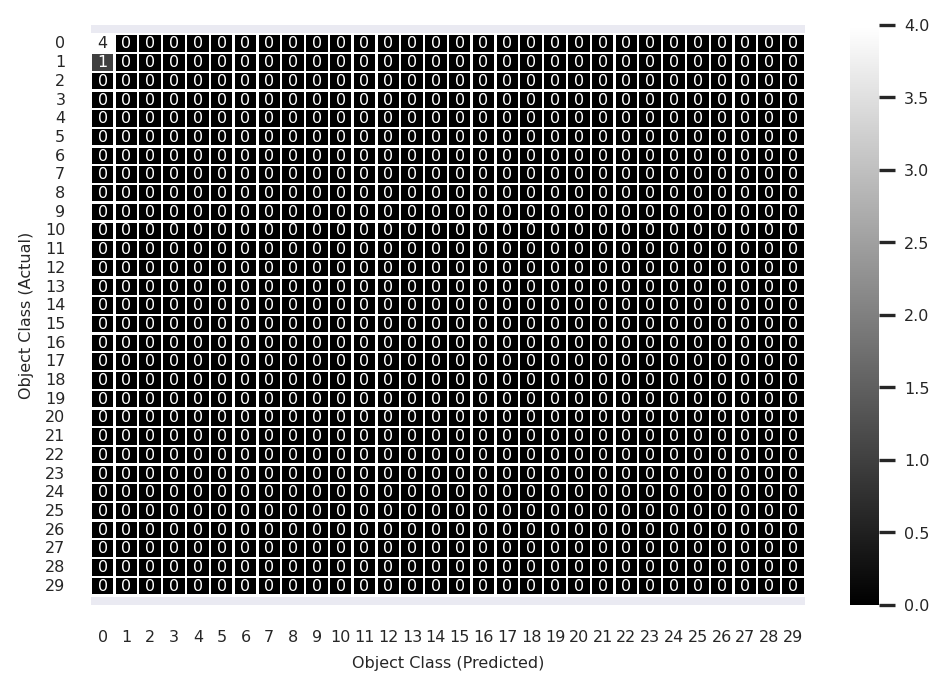

In [39]:
show_confusion_matrix(conf_matrix, n_per_class=n_samples_per_class)

## Comparing (Cosine) Similarity Between $\vec{\mu}$ Of Images and Their Reconstructions

In [648]:
mus, _, sigmas, xs = encoder(imgs)
zs = sampler((mus, sigmas))
xs_recon = decoder(zs)

In [649]:
recon_mus, _, recon_sigma, _ = encoder(xs_recon)

## For a Single Instance...

In [650]:
def display_image_and_recon(ndx):
    orig = imgs[ndx]
    orig_mu = np.expand_dims(mus[ndx], 0)

    recon = xs_recon[ndx]
    recon_mu = np.expand_dims(recon_mus[ndx], 0)

    fig = display_images([orig, recon], rows=1, cols=2, dpi=90, labels=['original', 'reconstruction'])

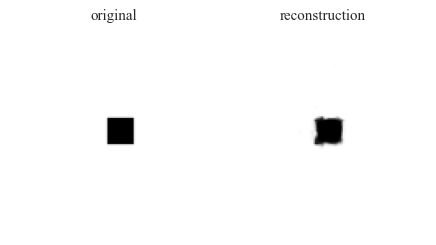

In [651]:
display_image_and_recon(ndx=0)

## Cosine Similarity Matrix Between $\vec{\mu}$ for Images and Their Reconstructions

In [652]:
recon_dist_matrix = cosine_similarity(recon_mus, mus)

### Most and Least Similar (Between Images and Their Reconstructions)

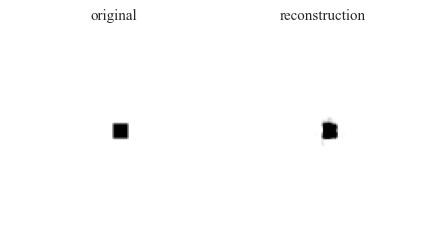

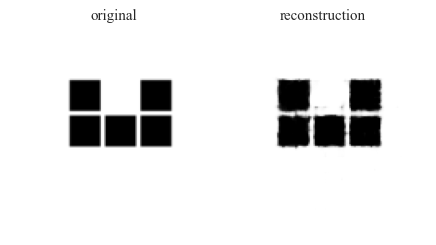

In [653]:
ndx_least_similar, ndx_most_similar = np.argmin(np.diag(recon_dist_matrix)), np.argmax(np.diag(recon_dist_matrix))

display_image_and_recon(ndx_most_similar)
display_image_and_recon(ndx_least_similar)

## Activation Heatmap Between Reconstructions and Original Images

In [654]:
# Passing the cosine similarity through a sigmoidal activation function
recon_act_matrix = np.copy(dist_matrix)

if using_activation:
    recon_act_matrix = curr_activation(act_matrix, a, b)
    
recon_act_matrix = np.round(recon_act_matrix, decimals=4)

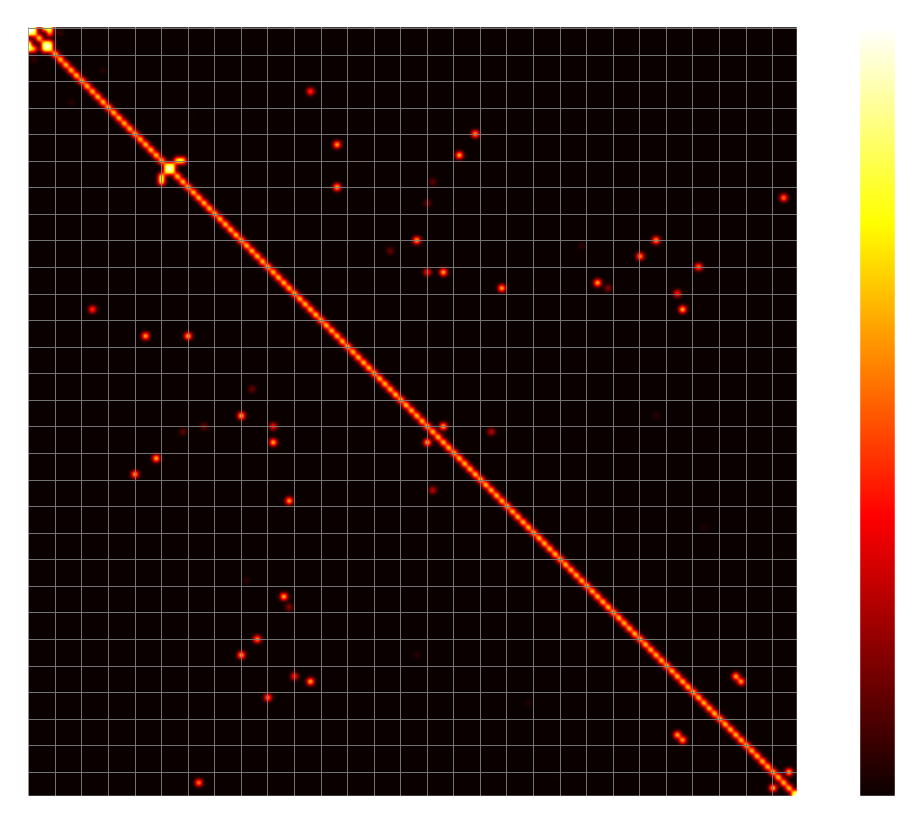

In [655]:
show_heatmap(recon_act_matrix, n=len(imgs), n_per_class=n_samples_per_class)

In [656]:
n_exemplars = recon_act_matrix.shape[0]

conf_matrix = np.zeros(shape=(n_classes + 1, n_classes + 1))
k = 5
act_threhold = 0.0

UNK_VALUE = np.array([[n_exemplars + 1, 0.0]])

for ndx in range(n_exemplars):
    
    # k most similar (removing "best match", which will be a self-reference)
    k_similar_set = get_n_similar(imgs, ndx, recon_act_matrix, k + 1)[1:]
    
    # remove examples below threshold
    k_similar_set = k_similar_set[k_similar_set[:,1] > act_threhold]
    
    # if all examples below threshold add UNKNOWN index
    if len(k_similar_set) == 0:
        k_similar_set = UNK_VALUE
               
    # calculate the object classes from indicies for most (cosine) similar
    obj_classes = k_similar_set[:,0].astype(int) // n_samples_per_class
    
    # determine best object class as object class with max number of members in most_similar_set
    predicted_class = np.argmax(np.bincount(obj_classes))
    actual_class = ndx // n_samples_per_class 
                
    conf_matrix[actual_class,predicted_class] += 1
        
print('overall accuracy: ', sum(np.diag(conf_matrix[0:10, 0:10]))/ np.sum(conf_matrix[0:10, 0:10]))

overall accuracy:  0.5882352941176471


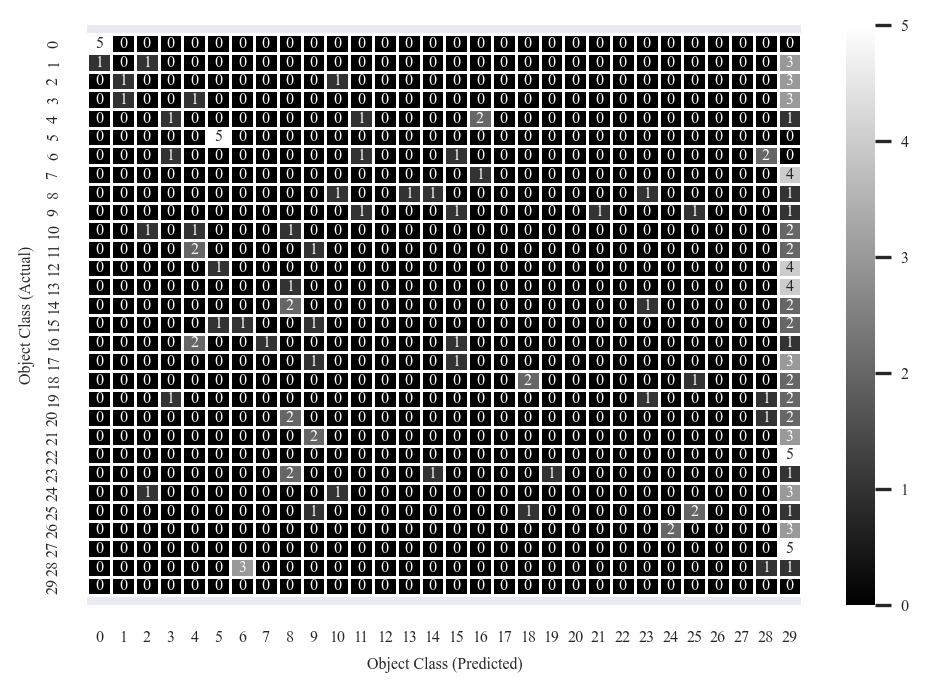

In [657]:
show_confusion_matrix(conf_matrix, n_per_class=n_samples_per_class)

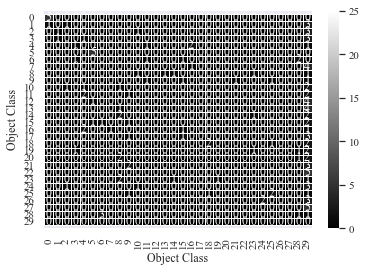

In [658]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rcParams['font.family'] ='Times New Roman'

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

fig = plt.figure()

ax = sns.heatmap(conf_matrix, annot=True, vmax=25, linewidths=.5, cmap="gist_gray", xticklabels=True, yticklabels=True)
ax.set_xlabel("Object Class")
ax.set_ylabel("Object Class")

# fix issue with plot cutting off top and bottom of image
b, t = ax.get_ylim()
b += 0.5
t -= 0.5
ax.set_ylim(b,t)

plt.show()

# uncomment to export image
# fig.savefig('knn_confmatrix.svg', format='svg')

# Rotation Analysis

In [659]:
def get_images_for_label(id):
    ds_options = {
        'directory': f'../data/images/{id}',
        'labels': None,
        'color_mode': "grayscale",
        'batch_size': 1,
        'image_size': INPUT_SHAPE[0:2],
        'shuffle': False,
    }

    poly_ds = tf.keras.utils.image_dataset_from_directory(**ds_options)
    
    # there must be a better way to do this...
    poly_imgs = None
    for img in list(poly_ds.as_numpy_iterator()):
        poly_imgs = img if poly_imgs is None else np.append(poly_imgs, img, axis=0)
        
    return poly_imgs

In [660]:
poly_imgs = get_images_for_label(1)

Found 27 files belonging to 1 classes.


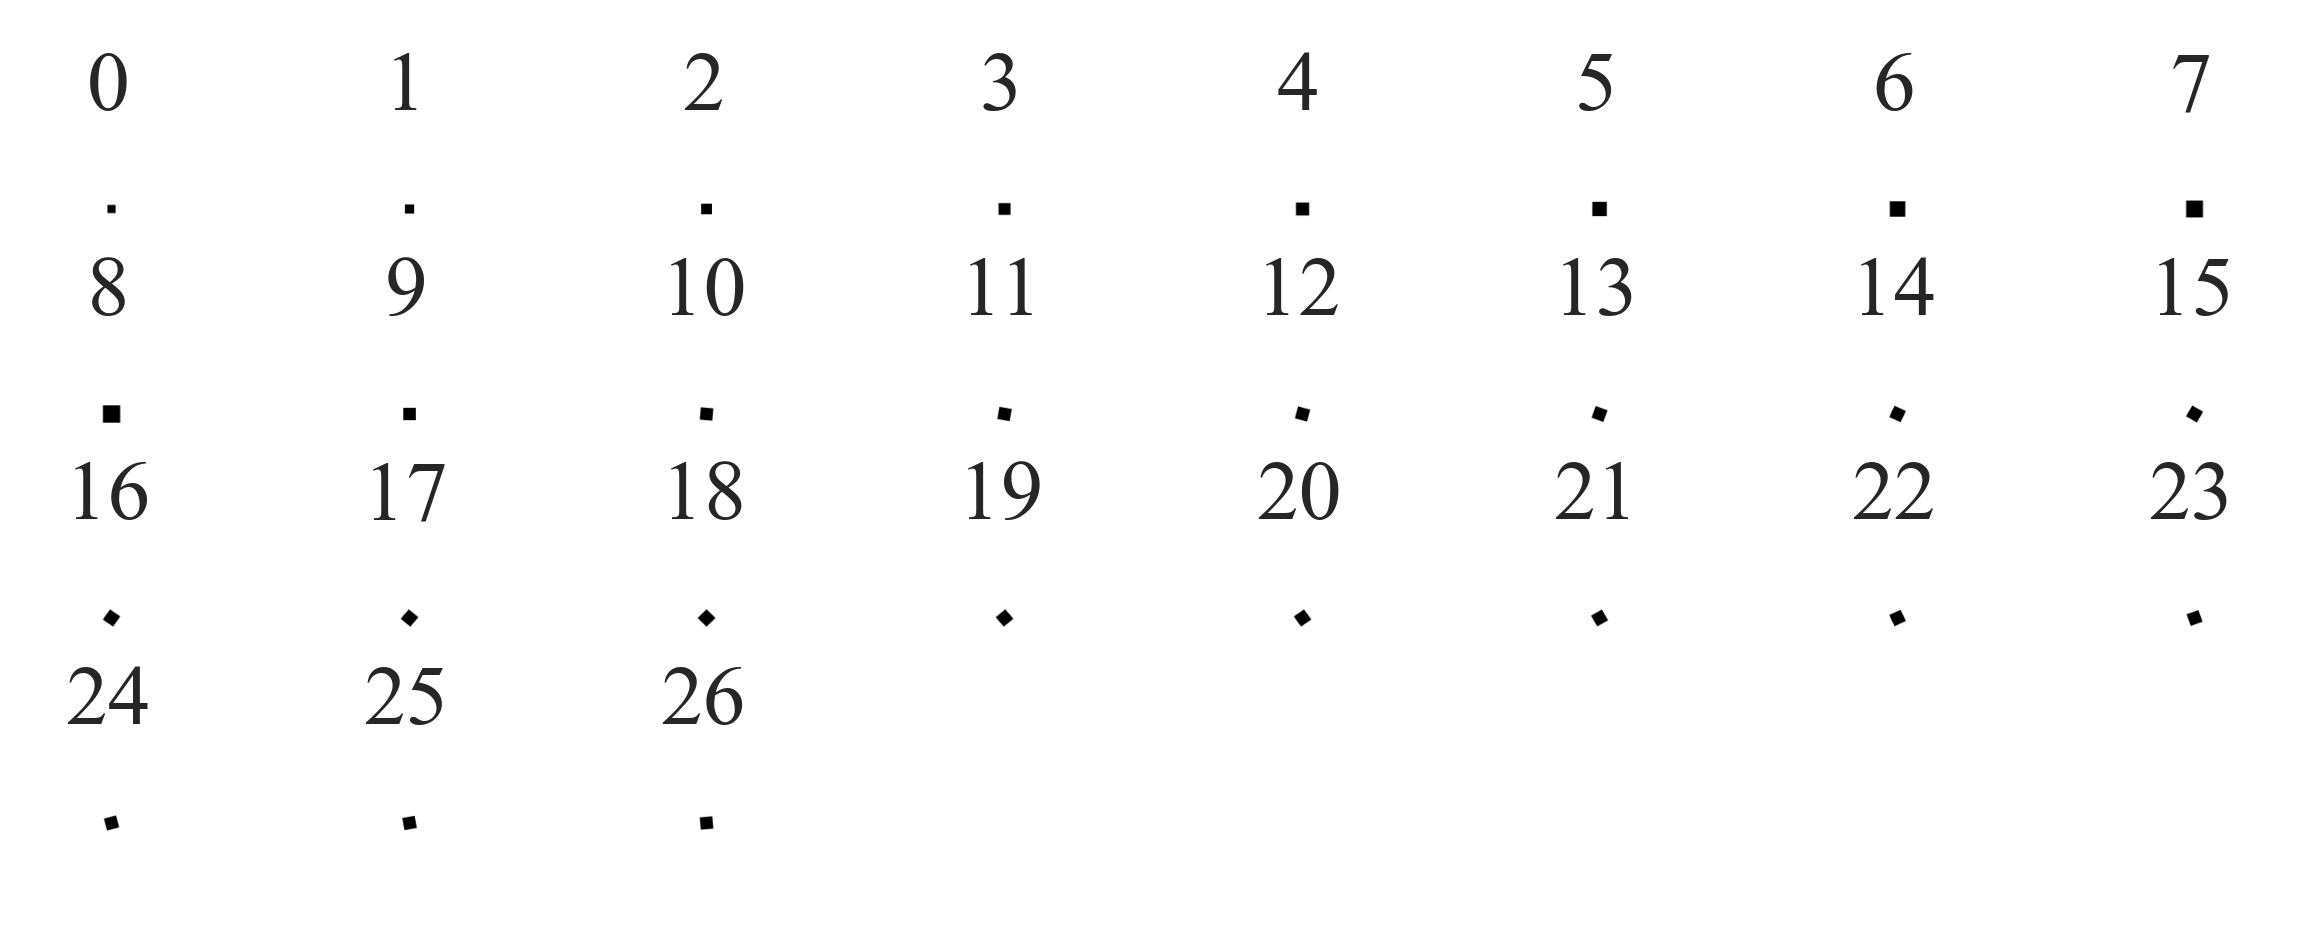

In [661]:
fig = display_images(poly_imgs, 8, 8, labels=range(poly_imgs.shape[0]), hspace=0.8, dpi=512)

In [662]:
# index of normal scale, upright image (used as a reference point for comparison)
ndx_of_ref = 9

In [664]:
mus, _, _, xs = encoder(poly_imgs[ndx_of_ref:])

In [665]:
cos_sims = cosine_similarity(mus)
cos_sims = np.round(cos_sims, decimals=4)

In [666]:
cos_sims[0]

array([1.    , 0.9721, 0.9074, 0.8482, 0.7697, 0.6865, 0.6232, 0.5545,
       0.5405, 0.5296, 0.5268, 0.5489, 0.6024, 0.6669, 0.7421, 0.8429,
       0.926 , 0.9752], dtype=float32)

In [674]:
t = cos_sims[ndx_of_ref]
most_diff = np.argmax(np.abs(t - np.ones_like(t)))
t[most_diff]

0.5296

In [675]:
most_diff_img = poly_imgs[most_diff]

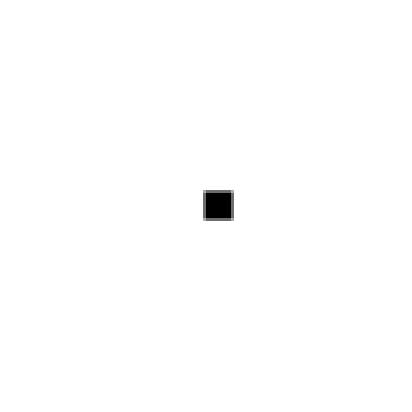

In [676]:
fig = display_images(most_diff_img[np.newaxis,...], 1, 1)